<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/main/notebooks/lab2-model-quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 2: Effiziente Quantisierung tiefer neuronaler Netze
- Dieses Jupyter Notebook **benötigt eine GPU Laufzeit**. Falls nicht bereits voreingestellt, kann daher der Laufzeittyp im Menü unter "Laufzeit" > "Laufzeittyp ändern" > "Hardwarebeschleuniger" > **"T4 GPU"** geändert werden!

# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [ ]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
# %%capture
!pip install "techdays25[lab2] @ git+https://github.com/MarkusThill/techdays25.git@main"

<font color="red"><b>
⚠️ WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden (Menü > Laufzeit > Sitzung neu starten)! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden. ⚠️
</font></b>

In [ ]:
!git clone "https://github.com/MarkusThill/techdays25.git"
!cd techdays25 && git checkout main

In [ ]:
# @title Colab-spezifische Konfigurationen {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

# 📘 Einleitung und Gliederung

Dieses Jupyter Notebook ist in 4 Teile gegliedert. Es empfiehlt sich, die einzelnen Teile von vorne beginnend, nacheinander durchzuarbeiten.

- 📖 Teil 1: Darstellung numerischer Datentypen
  - In diesem Teil wiederholen wir verschiedene Darstellungen von numerischen Datentypen und lernen in einem interaktivem Modul die Unterschiede zwischen diesen kennen.
- 🔢 Teil 2 (Optional): Quantisierung eines linearen Regressionsmodells (aus Lab 1)
- 🕸 Teil 3 (Optional): Gotchas bei der Modellquantisierung am Beispiel eines einfachen Modells
- 📞 Teil 4: Quantisierung eines DTMF Klassifikationsmodells

# 📖 Teil 1: Darstellung numerischer Datentypen

### Ganzahldarstellungen/Zweierkomplementdarstellung

In [ ]:
# @title Darstellung von 8-Bit Integer Zahlen {display-mode: "form"}

import ipywidgets as widgets
from IPython.display import HTML, display

# Initialize 8 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="40px")
    )
    for _ in range(8)
]

# Color bars for sign and integer part
color_bars = [
    widgets.HTML(
        value='<div style="width: 40px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 40px; height: 10px; background-color: green;"></div>'
    )
    for i in range(8)
]

# Output widget to show results
output = widgets.Output()


def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Hex representation (2 hex digits for 8 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:]}</span>
            </code><br>
            Vorzeichenlose Dezimalzahl: <b>{unsigned_decimal}</b><br>
            Vorzeichenbehaftete Dezimalzahl (Zweierkomplement): <b>{signed_decimal}</b><br>
            Hexadezimaldarstellung: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize display
update_display()

#### Übungsfragen (Optional):

- Was ist die größtmögliche bzw. kleinstmögliche Zahl die mit 8 Bit dargestellt werden können?
- Signed vs. Unsigned Darstellung: Setze das 8. Bit (höchstwertiges Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
- Was charakterisiert eine negative Zahl in der Zweierkomplementdarstellung (unsigned integer) im Allgmeinen?
- Wie negiere ich eine Zahl (z.B. 32 -> -32 bzw. -71 -> 71)?
- Angenommen ich habe -33 als 8-bit Zahl vorliegen. Wie würde ich daraus eine 32-bit unsigned Integer Zahl machen?
- Maximale und minimale Werte: Was ist der maximale/minimale Wert, den man mit einer 8-Bit signed/unsigned Zahl darstellen kann?
- Alle Bits gesetzt: Setze alle Bits einer 8-Bit-Zahl auf 1. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?

### Fixkommadarstellungen

In [ ]:
# @title Darstellung von 16-Bit Integer/Festkomma-Zahlen {display-mode: "form"}
import ipywidgets as widgets
from IPython.display import display

# Initialize 16 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, integer part, and fractional part
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 7
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show results
output = widgets.Output()


def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented


def fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to a fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = twos_complement(integer_part)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value


def unsigned_fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to an unsigned fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The unsigned fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = int("".join(str(b) for b in integer_part), 2)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Fixed-point value
    fixed_point_decimal = fixed_point_value(bit_values)

    # Unsigned fixed-point value
    unsigned_fixed_point_decimal = unsigned_fixed_point_value(bit_values)

    # Hex representation (4 hex digits for 16 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:8]}</span>.
                <span style="color: blue;">{bit_string[8:]}</span>
            </code><br>
            Vorzeichenlose Dezimalzahl: <b>{unsigned_decimal}</b><br>
            Vorzeichenbehaftete Dezimalzahl (Zweierkomplement): <b>{signed_decimal}</b><br>
            Vorzeichenlose Festkommazahl: <b>{unsigned_fixed_point_decimal}</b><br>
            Vorzeichenbehaftete Festkommazahl (Zweierkomplement): <b>{fixed_point_decimal}</b><br>
            Hexadezimaldarstellung: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


def reset_bits(*args) -> None:
    """Reset all toggle buttons to their initial state (False)."""
    for btn in bit_toggles:
        btn.value = False


# Create reset button
reset_button = widgets.Button(description="Reset", layout=widgets.Layout(width="100px"))
reset_button.on_click(reset_bits)

# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(
    widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars), reset_button])
)
display(output)

# Initialize display
update_display()

#### Übungsfragen (Optional):
- Was ist die kleinstmögliche vorzeichenbehaftete Festkommazahl?
- Wie stelle ich -1.25 als Festkommazahl dar?
- Was ist die kleinstmögliche (größtmögliche) Festkommazahl größer (kleiner) als Null?

In [ ]:
# @title Darstellung von 16-Bit (FP16) Fließkommazahlen nach IEEE 754 {display-mode: "form"}

import struct

import ipywidgets as widgets
import numpy as np
from IPython.display import display

# Initialize 16 toggle buttons (bits)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, exponent, and mantissa
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 5
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show FP16 value and components
output = widgets.Output()


def bits_to_float16(bits: list[int]) -> np.float16:
    """Convert list of bits to FP16 float value.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        np.float16: The FP16 float value of the binary number.
    """
    bit_string = "".join(str(b) for b in bits)
    # Convert binary string to integer
    int_value = int(bit_string, 2)
    # Pack as unsigned 16-bit int, then unpack as float16 using numpy
    packed = struct.pack("<H", int_value)  # Big endian 16-bit unsigned int
    return np.frombuffer(packed, dtype=np.float16)[0]


def update_display(*args):
    """Update the display with the current binary, FP16 float value, and its components."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Extract components
    sign = bit_values[0]
    exponent_bits = bit_values[1:6]
    mantissa_bits = bit_values[6:]

    exponent = int("".join(str(b) for b in exponent_bits), 2)
    exponent_unbiased = exponent - 15  # Bias = 15

    mantissa_raw = "".join(str(b) for b in mantissa_bits)
    mantissa_value = (
        1 + sum(int(b) * 2 ** (-i) for i, b in enumerate(mantissa_bits, start=1))
        if exponent != 0
        else 0
    )

    # Convert to float16 value
    fp16_value = bits_to_float16(bit_values)

    # Clear previous output and display new info
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binärdarstellung: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:6]}</span>
                <span style="color: blue;">{bit_string[6:]}</span>
            </code><br>
            Vorzeichen (1 bit): <b>{sign}</b> ({"-" if sign else "+"})<br>
            Exponent (5 bits): <b>{"".join(str(b) for b in exponent_bits)} (biased: {exponent}, unbiased: {exponent_unbiased})</b><br>
            Mantisse (10 bits): <b>{mantissa_raw}</b><br>
            <hr>
            <b>FP16 Dezimaldarstellung: {fp16_value} </b>
        </h3>
        """)
        )

    # Update button labels
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


def reset_bits(*args) -> None:
    """Reset all toggle buttons to their initial state (False)."""
    for btn in bit_toggles:
        btn.value = False


# Create reset button
reset_button = widgets.Button(description="Reset", layout=widgets.Layout(width="100px"))
reset_button.on_click(reset_bits)

# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(
    widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars), reset_button])
)
display(output)

# Initialize output
update_display()  # 0 01111 0000000001 ^=^ 1.00097656

#### Übungsfragen (Optional):
- Wie würde ich 1.0, 0.5 und 7.0 darstellen?
- Was ist die größte/kleinste darstellbare Zahl?
- Gibt es einen Unterschied zwischen +0.0 und -0.0?
- Wie stelle ich `+Inf` bzw. `-Inf` dar?
- Wie stelle ich `NaN` dar?
- Was ergibt der Vergleich `float("nan") != float("nan")`?

# 🔢 Teil 2 (Optional): Quantisierung eines linearen Regressionsmodells (aus Lab 1)

- In diesem Abschnitt werden wir das lineare ONNX-Regressions-Modell, das wir in Lab 1 erzeugt haben, quantisieren und uns die Ergebnisse für verschiedene Quantisierungsstufen (FP32, FP16, INT8) anschauen.

In [ ]:
# Load necessary libs
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import onnx
import pandas as pd
from onnxconverter_common import float16

from techdays25.onnx_utils import (
    OnnxModel,
    benchmark_models_on_batch_size,
)
from techdays25.plotting_utils import plot_benchmark_results

In [ ]:
# Specify, which model to use
onnx_model_path = Path("techdays25/assets/lab1/pytorch_regression.onnx")

In [ ]:
# Visualize the model again
from techdays25 import onnx_utils

onnx_utils.netron_visualize(str(onnx_model_path))

## Quantisiere ONNX Modell nach FP16

In [ ]:
# Load the previously saved FP32 ONNX model
regression_model_fp32 = onnx.load(onnx_model_path)

# Convert the FP32 ONNX model to FP16 precision
# The keep_io_types=True argument ensures that the input and output types remain the same
onnx_model_fp16 = float16.convert_float_to_float16(
    regression_model_fp32,  # path to the onnx model
    min_positive_val=1e-7,  # Constant values will be clipped to these bounds
    max_finite_val=1e4,  # same as above
    keep_io_types=True,  # If set to false, the IO types will change to FP16
    disable_shape_infer=False,  # Skips running onnx shape/type inference
    op_block_list=None,  # A list of OPs which shall not be quantized
    node_block_list=None,  # A list of nodes which shall not be converted
)

# Define the path where the FP16 ONNX model will be saved
onnx_model_fp16_path = onnx_model_path.stem + "_fp16" + onnx_model_path.suffix

# Save the converted FP16 ONNX model to the specified path
onnx.save(onnx_model_fp16, onnx_model_fp16_path)

# Print a message indicating that the FP16 ONNX model has been saved successfully
print(f"ONNX model (FP16) saved to {onnx_model_fp16_path}")

## Quantisiere Modell nach INT8

In [ ]:
# Imports
from typing import Any

import numpy as np
from onnxruntime.quantization import (
    CalibrationDataReader,
    QuantType,
    quantize_dynamic,
    quantize_static,
)
from onnxruntime.quantization.shape_inference import quant_pre_process

In [ ]:
# First try static quantization and then switch to dynamic quantization
# and see how the results change
static_quantization = True  # toggles between static and dynamic quantization
onnx_model_path_int8 = onnx_model_path.stem + "_int8.onnx"

#
quant_pre_process(onnx_model_path, onnx_model_path_int8 + ".pre")


class CalibrationDataReaderImpl(CalibrationDataReader):
    """A class for constructing calibration data for the ONNX INT8 calibration."""

    def __init__(self) -> None:
        """Initialize the CalibrationDataReaderImpl.

        This class implements a calibration data reader for INT8 calibration.
        It generates synthetic data for calibration purposes.
        """
        self.counter: int = 0

    def get_next(self) -> dict[str, Any] | None:
        """Get the next batch of calibration data.

        This method generates synthetic data for calibration. It returns None after 16 batches.

        Returns:
            Optional[Dict[str, Any]]: A dictionary containing the input data for calibration,
            or None if there are no more batches.
        """
        if self.counter >= 16:
            return None
        self.counter += 1
        X = np.linspace(-10, 10, 1000).reshape(-1, 1)
        return {"input": X.astype(np.float32)}


# Prepare calibration data
calibration_data_reader = CalibrationDataReaderImpl()

if static_quantization:
    quantize_static(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        calibration_data_reader,
        # quant_format=QuantFormat.QOperator,
        per_channel=True,
        weight_type=QuantType.QInt8,
    )
else:
    quantize_dynamic(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        weight_type=QuantType.QInt8,  # Quantize weights to int8
        per_channel=True,  # Enable per-channel quantization
        reduce_range=True,  # Reduce the quantization range
    )

In [ ]:
from pathlib import Path
from typing import Any

import numpy as np
from onnxruntime.quantization import (
    CalibrationDataReader,
    QuantType,
    quantize_dynamic,
    quantize_static,
)
from onnxruntime.quantization.shape_inference import quant_pre_process

In [ ]:
onnx_model_path = Path("techdays25/assets/lab1/pytorch_regression.onnx")

# First try static quantization and then switch to dynamic quantization
# and see how the results change
static_quantization = True  # toggles between static and dynamic quantization
onnx_model_path_int8 = onnx_model_path.stem + "_int8.onnx"

# Shape inference and model optimization, in preparation for quantization.
quant_pre_process(onnx_model_path, onnx_model_path_int8 + ".pre")


class CalibrationDataReaderImpl(CalibrationDataReader):
    """A class for constructing calibration data for the ONNX INT8 calibration."""

    def __init__(self) -> None:
        """Initialize the CalibrationDataReaderImpl.

        This class implements a calibration data reader for INT8 calibration.
        It generates synthetic data for calibration purposes.
        """
        self.counter: int = 0

    def get_next(self) -> dict[str, Any] | None:
        """Get the next batch of calibration data.

        This method generates synthetic data for calibration. It returns None after 16 batches.

        Returns:
            Optional[Dict[str, Any]]: A dictionary containing the input data for calibration,
            or None if there are no more batches.
        """
        if self.counter >= 16:
            return None
        self.counter += 1
        X = np.linspace(-10, 10, 1000).reshape(-1, 1)
        return {"input": X.astype(np.float32)}


# Prepare calibration data
calibration_data_reader = CalibrationDataReaderImpl()

if static_quantization:
    quantize_static(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        calibration_data_reader,
        # quant_format=QuantFormat.QOperator,
        per_channel=True,
        weight_type=QuantType.QInt8,
        extra_options={"CalibTensorRangeSymmetric": True},
    )
else:
    quantize_dynamic(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        weight_type=QuantType.QInt8,  # Quantize weights to int8
        per_channel=True,  # Enable per-channel quantization
        reduce_range=True,  # Reduce the quantization range
    )

## Netron Visualisierung der ONNX Modelle

In [ ]:
from techdays25 import onnx_utils

# Change model path accordingly:
onnx_utils.netron_visualize("pytorch_regression_int8.onnx")

## Vergleich der quantisierten Modellvarianten mit ursprünglichem Modell

In [ ]:
reg_model_fp32_cpu = OnnxModel(onnx_model_path, provider="CPUExecutionProvider")
reg_model_fp16_cpu = OnnxModel(onnx_model_fp16_path, provider="CPUExecutionProvider")
reg_model_int8_cpu = OnnxModel(onnx_model_path_int8, provider="CPUExecutionProvider")

reg_model_fp32_gpu = OnnxModel(onnx_model_path, provider="CUDAExecutionProvider")
reg_model_fp16_gpu = OnnxModel(onnx_model_fp16_path, provider="CUDAExecutionProvider")
reg_model_int8_gpu = OnnxModel(onnx_model_path_int8, provider="CUDAExecutionProvider")

print("\nSpezifikation des FP16 Modells:")
print(reg_model_fp16_cpu)

In [ ]:
# Create some random data and compare the results of the FP16 and FP32 models
u_range = (-10, 10)  # set range for which input values shall be generated

models = {
    "FP32/CPU": reg_model_fp32_cpu,  # first model is the reference
    "FP16/CPU": reg_model_fp16_cpu,
    # "INT8/CPU": reg_model_int8_cpu,
    # "FP32/GPU": reg_model_fp32_gpu,
    "FP16/GPU": reg_model_fp16_gpu,
    "INT8/GPU": reg_model_int8_gpu,
}

uu = np.linspace(*u_range, 15).reshape(-1, 1).astype(np.float32)
ii_predictions = {k: m.predict(uu).flatten() for k, m in models.items()}

# Extract the first key-value pair (this is the reference)
first_key = next(iter(ii_predictions))
first_value = ii_predictions[first_key]
ii_diffs = {
    "Δ" + k: first_value - v for k, v in ii_predictions.items() if k != first_key
}

df_data = {"Input [U/V]": uu.flatten()}

df_data.update(ii_predictions)
df_data.update(ii_diffs)

pd.DataFrame(df_data)

### Fragen (Optional)
- Wie verhalten sich die Modellausgaben/Differenzen der beiden obigen Modelle für unterschiedliche Bereiche, die in `u_range` spezifiziert werden, z.B. für `u_range=(0,100)` oder `u_range=(-1000, 1000)`?
- Wie lassen sich mögliche Abweichungen erklären?

In [ ]:
# Comment/Uncomment the lines in `models` to unselect/select certain models
models = {
    "FP32/CPU": reg_model_fp32_cpu,  # first model is the reference
    # "FP16/CPU": reg_model_fp16_cpu,
    # "INT8/CPU": reg_model_int8_cpu,
    # "FP32/GPU": reg_model_fp32_gpu,
    "FP16/GPU": reg_model_fp16_gpu,
    "INT8/GPU": reg_model_int8_gpu,
}

# systematically evaluate the model differences for a given range
uu = np.linspace(-20, 20, 100000).reshape(-1, 1).astype(np.float32)

ii_predictions = {k: m.predict(uu).flatten() for k, m in models.items()}
# Extract the first key-value pair (this is the reference)
ref_key = next(iter(ii_predictions))
ref_value = ii_predictions[ref_key]
ii_diffs = {k: ref_value - v for k, v in ii_predictions.items() if k != ref_key}

plt.figure(figsize=(10, 5))
for k, v in ii_diffs.items():
    plt.plot(uu, v, label=k)

plt.grid(which="both")
plt.xlabel("U [V]")
plt.ylabel(r"$\Delta \hat{I}_{ref}$ [mA]")
plt.legend()
plt.title(f"Abweichungen diverser ONNX Modelle zur Referenz {first_key}")
plt.show()

### Fragen (Optional)
- Unterscheiden sich die Kurven für INT8/CPU (FP16/CPU) und INT8/GPU (FP16/GPU)? Wieso?
- Wie ist das Verhalten der Kurven für die INT8-Modelle (statisch quantisiert) bei $\pm 10.0$ zu erklären?
- Gibt es Unterschiede zwischen den statisch und dynamische quantisierten INT8 Modellen?


## Messung der Inferenzzeiten für die quantisierten Modelle
- Wir variieren die Batch-Size und messen die Laufzeit für jeweils $n$ Durchläufe

In [ ]:
# measure inference times/latency for different batch sizes

batch_sizes = [2**i for i in range(10, 22)]
model_dict = {
    "ONNX Regression Model (FP32/CPU)": reg_model_fp32_cpu.predict,
    # "ONNX Regression Model (FP16/CPU)": reg_model_fp16_cpu.predict,
    # "ONNX Regression Model (INT8/CPU)": reg_model_int8_cpu.predict,
    "ONNX Regression Model (FP32/GPU)": reg_model_fp32_gpu.predict,
    "ONNX Regression Model (FP16/GPU)": reg_model_fp16_gpu.predict,
    "ONNX Regression Model (INT8/GPU)": reg_model_int8_gpu.predict,
}

benchmark_results = benchmark_models_on_batch_size(
    model_dict=model_dict,
    input_shape=(1,),
    batch_sizes=batch_sizes,
    n_runs=100,
    verbose=True,
)

In [ ]:
plot_benchmark_results(
    results=benchmark_results,
    title="Laufzeiten der unterschiedlichen quantisierten Modelle",
    xscale="log",
    yscale=None,
)

### Fragen (Optional)
- Wie stark ist der Einfluss der Quantisierungen bei diesem Modell auf die Laufzeit?
- Wie ist das Laufzeitverhalten des statisch vs. dynamisch quantisierten Modells?

# 🕸 Teil 3 (Optional): Gotchas bei der Modellquantisierung am Beispiel eines einfachen Modells

In diesem Teil werden wir uns damit befassen, welche Probleme bei der Modellquantisierung auftreten können und dies anhand eines Beispiels illustrieren. Folgende Schritte werden durchgeführt:
- Erstellen eines benutzerdefinierten Modells in Keras zur Mittelwertbildung entlang der Zeitachse.
- Konvertieren des Keras-Modells in das ONNX-Format.
- Quantisieren des ONNX-Modells von FP32 auf FP16.
- Generierung von 3-dimensionalen Zeitreihendaten für die Modellinferenz.
- Modellinferenz mit dem Keras-Modell.
- Modellinferenz mit den FP32/FP16 ONNX-Modellen:
  - Laden und Ausführen von ONNX-Modellen mit der ONNX Runtime.
  - Vergleich der Ausgaben von FP32- und FP16-ONNX-Modellen.
- Diskussion der Beobachtungen und möglicher Lösungen.


## Modelldefinition

Unser Modell unten nimmt einen 3-dimensionalen Eingabetensor mit den Dimensionen (Batch-Größe, Sequenzlänge, Merkmalsanzahl) entgegen. In unserem Beispiel hat der Eingabetensor die Form (2, 10000, 3), was bedeutet, dass wir zwei Batch-Elemente haben, jedes mit einer Sequenzlänge von 10000 und 3 Merkmalen pro Zeitschritt.

Nach der Verarbeitung durch das Modell wird die Zeitdimension reduziert, und die Ausgabe hat die Form (Batch-Größe, Merkmalsanzahl). Für unser Beispiel ergibt sich eine Ausgabe mit der Form (2, 3). Die Ausgabe repräsentiert den Durchschnitt der Merkmale über die gesamte Sequenzlänge für jedes Batch-Element.

**Beispiel (Visuelles Beispiel weiter unten)**

Eingabetensor (2 x 4 x 3):
```
[
  [
    [3, 4, 5],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
  ],
  [
    [2, 4, 6],
    [8, 10, 12],
    [14, 16, 18],
    [20, 22, 24]
  ]
]
```

Ausgabetensor (2 x 3):
```
[
  [ 6,  7,  8],
  [11, 13, 15]
]
```


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Layer


class SumLayer(Layer):
    """Custom Layer to sum over time dimension of a tensor."""

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Reduce (sum) the input tensor along the time axis (axis=1).

        Args:
            inputs (tf.Tensor): The input tensor of shape (batch_size, sequence_length, feature_dim).

        Returns:
            tf.Tensor: The reduced tensor of shape (batch_size, feature_dim).
        """
        return tf.reduce_sum(inputs, axis=1)


# Custom Layer: Division by sequence length
class DivisionLayer(Layer):
    """Divide a tensor by the length of the given sequence."""

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
        """Divide the summed tensor by the sequence length to get the average.

        Args:
            inputs (Tuple[tf.Tensor, tf.Tensor]): A tuple containing the summed tensor and the original input tensor.
                - tensor_x (tf.Tensor): The summed tensor of shape (batch_size, feature_dim).
                - original_input (tf.Tensor): The original input tensor of shape (batch_size, sequence_length, feature_dim).

        Returns:
            tf.Tensor: The averaged tensor of shape (batch_size, feature_dim).
        """
        tensor_x, original_input = inputs
        seq_length = tf.shape(original_input)[
            1
        ]  # Get the dynamic sequence length (length of the time dimension)
        return tensor_x / tf.cast(seq_length, dtype=tensor_x.dtype)


# Define model with separate Sum and Division layers
def global_average_pooling_1d() -> Model:
    """Define a Keras model with separate Sum and Division layers for global average pooling.

    Returns:
        Model: A Keras model that performs global average pooling over the time dimension.
    """
    inputs = Input(
        shape=(None, 3), name="input"
    )  # Define the input layer with shape (sequence_length=None, feature_dim=3)
    sum_x = SumLayer(name="sum")(inputs)  # Apply the SumLayer to the inputs
    output = DivisionLayer(name="divide")([
        sum_x,
        inputs,
    ])  # Apply the DivisionLayer to the summed tensor and the original inputs
    return Model(
        inputs, output, name="GlobalAveragePooling1D"
    )  # Create the Keras model with the specified input and output


# Create the model
model = global_average_pooling_1d()

# Print model summary to see the architecture
model.summary()

## Beispiel

In [ ]:
import numpy as np

# Generate sample data
batch_size = 2
sequence_length = 5
feature_dim = 3
np.random.seed(0)
sample_data = (
    np.random.rand(batch_size, sequence_length, feature_dim).astype(np.float32).round(1)
)
print(f"Input {str(sample_data.shape).replace(',', ' x')}:\n", sample_data)

# Pass data through the model
output_data = model.predict(sample_data, verbose=0)

# Print the output
print(f"\nOutput {str(output_data.shape).replace(',', ' x')}:\n", output_data)

In [ ]:
# @title Visualisierung der obigen Beispieldaten {display-mode: "form"}

import matplotlib.pyplot as plt


# Visualize the input and output
def plot_data(input_data, output_data):
    batch_size, sequence_length, feature_dim = input_data.shape
    gap_size = 1  # Size of the gap between rows and columns
    total_cols = sequence_length + 1 + gap_size  # Include gap for output column
    total_rows = feature_dim + gap_size  # Include gap between rows

    fig, axes = plt.subplots(nrows=batch_size, ncols=1, figsize=(9, 3 * batch_size))

    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        data_with_output = np.full(
            (feature_dim, total_cols), np.nan
        )  # Initialize with NaNs for gaps
        data_with_output[:, :sequence_length] = input_data[
            i
        ].T  # Fill input data (transpose to match dimensions)
        data_with_output[:, sequence_length + gap_size] = output_data[
            i
        ]  # Fill output data

        cax = ax.matshow(data_with_output, cmap="Blues", vmin=0, vmax=1)

        for (j, k), val in np.ndenumerate(data_with_output):
            if not np.isnan(val):
                ax.text(k, j, f"{val:.2f}", ha="center", va="center", color="black")

        ax.set_xticks(np.arange(total_cols))
        ax.set_xticklabels(
            [f"$t_{t}$" for t in range(sequence_length)]
            + [""] * gap_size
            + ["Modell-Output"]
        )
        ax.set_yticks(np.arange(feature_dim))
        ax.set_yticklabels([f"Kanal {f}" for f in range(feature_dim)])
        ax.set_title(f"Signal {i + 1}")

        # Remove tick lines and surrounding border
        ax.tick_params(axis="both", which="both", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_data(sample_data, output_data)

## Modellkonvertierung nach ONNX

In [ ]:
# Convert our GlobalAveragePooling1D Model to ONNX format
import onnx  # ONNX library for handling ONNX models
import tf2onnx  # TensorFlow to ONNX conversion library
from onnxconverter_common import float16  # Utility for FP16 conversion

# Define the path where the FP32 ONNX model will be saved
onnx_model_path_fp32 = "gap1d_model_fp32.onnx"

# Convert the Keras model to ONNX format with FP32 precision
# Define the input specification for the model conversion
spec = (tf.TensorSpec((None, None, 3), tf.float32, name="input"),)
# Convert the Keras model to ONNX using tf2onnx
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=18)

# Save the converted FP32 ONNX model to the specified path
onnx.save(onnx_model, onnx_model_path_fp32)
print(f"ONNX model (FP32) saved to {onnx_model_path_fp32}")

## Quantisierung des ONNX Modells

In [ ]:
# Now quantize the ONNX model to FP16 and save it

# Load the previously saved FP32 ONNX model
onnx_model_fp32 = onnx.load(onnx_model_path_fp32)

# Convert the FP32 ONNX model to FP16 precision
# The keep_io_types=True argument ensures that the input and output types remain the same
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model_fp32, keep_io_types=True)

# Define the path where the FP16 ONNX model will be saved
onnx_model_path_fp16 = "gap1d_model_fp16.onnx"

# Save the converted FP16 ONNX model to the specified path
onnx.save(onnx_model_fp16, onnx_model_path_fp16)

# Print a message indicating that the FP16 ONNX model has been saved successfully
print(f"ONNX model (FP16) saved to {onnx_model_path_fp16}")

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("gap1d_model_fp16.onnx")

## Datengenerierung

In [ ]:
# First create some data and put it through the Keras model
import matplotlib.pyplot as plt  # Library for plotting
import numpy as np  # Library for numerical operations

# Create a random input tensor with a batch size of 2
# Generate a sequence of numbers from 0 to 9999 and reshape it to (1, 10000, 1)
tt = np.arange(10_000).reshape(1, -1, 1)

# Create an offset array and reverse it
off = (np.array(np.arange(6)).astype(np.float32) + 4)[::-1]

# Generate a 3-dimensional time series data using a sine function with the offset
xx = 0.4 * np.sin(4 * np.pi * 1e-5 * off**2 * tt) + off

# Reshape the data to have dimensions (sequence_length, batch_size, feature_dim)
xx = xx.reshape(-1, 2, 3)

# Swap the axes to get the shape (batch_size, sequence_length, feature_dim)
xx = np.swapaxes(xx, 0, 1)

# Convert the data to float32 type
x_input = xx.astype(np.float32)

# Print the dimensions of the input tensor
print("Dimensions of the input tensor:", x_input.shape)

In [ ]:
# Plot the generated time series data
import matplotlib.pyplot as plt  # Library for plotting (re-imported for completeness)

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the first batch (b$_1$) of the time series data
plt.plot(xx[0, :, :], label="b$_1$")

# Plot the second batch (b$_2$) of the time series data
plt.plot(xx[1, :, :], label="b$_2$")

# Set the label for the x-axis
plt.xlabel("t")

# Set the label for the y-axis
plt.ylabel("Amplitude")

# Set the title of the plot
plt.title("Ein Batch bestehend aus jeweils zwei 3-dimensionalen Zeitreihen")

# Add a legend to the plot
plt.legend(loc="upper center", bbox_to_anchor=(1.1, 0.6), ncol=2)

# Display the plot
plt.show()

## Inferenz mit dem Keras Modell

In [ ]:
# Put the data through the Keras model

# Use the Keras model to make predictions on the input data
y_output_keras = model.predict(x_input, verbose=0)

# Print the dimensions of the input tensor
print(
    "Dimensionen des Eingabetensors:", str(x_input.shape).replace(",", " x")
)  # Erwartete Form: (2, 10000, 3)

# Print the dimensions of the Keras model output
print(
    "Dimensionen der Keras-Modellausgabe:", str(y_output_keras.shape).replace(",", " x")
)  # expected shape: (2, 3) -> reduced time axis!

# Print the output of the Keras model
print("\nKeras-Modellausgabe:\n", y_output_keras)

## Inferenz mit den FP32/FP16 ONNX Modellen

In [ ]:
from techdays25.onnx_utils import OnnxModel

# Run the FP32 ONNX model
y_output_onnx_fp32 = OnnxModel(onnx_model_path="gap1d_model_fp32.onnx").predict(x_input)

# Print the output of the FP32 ONNX model
print("\nONNX (FP32) Modellausgabe:\n", y_output_onnx_fp32)

In [ ]:
# Run the FP16 ONNX model
y_output_onnx_fp16 = OnnxModel(onnx_model_path="gap1d_model_fp16.onnx").predict(x_input)

# Print the output of the FP32 ONNX model
print("\nONNX (FP16) Modellausgabe:\n", y_output_onnx_fp16)

## Fragen / Diskussion
- Welche Ergebnisse erwarten wir? Stimmen die Ergebnisse mit den Erwartungen überein?
- Was fällt bei der Ausgabe des quantisierten FP16 Modells auf?
  - Wie könnte man sich dieses Ergebnis erklären?
  - Lässt sich das Problem ggfs. vermeiden?


# 📞 Teil 4: Quantisierung eines DTMF Klassifikationsmodells

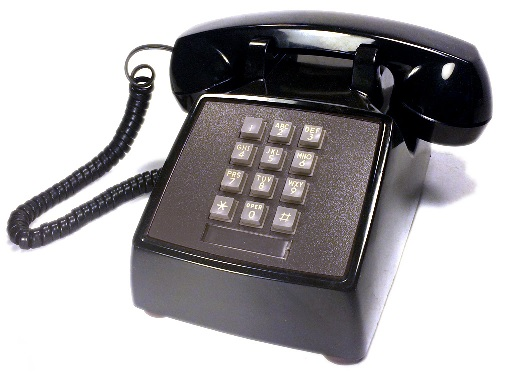

## Einführung: Generierung und Dekodierung/Klassifizierung von DTMF (dual-tone multi-frequency) Signalen <a class="anchor" id="part0"></a>


Das Dualton-Mehrfrequenzwahlverfahren (DTMF) ist ein Signalisierungssystem für das Wählen eines Telefons, das in den frühen 1960er Jahren von Western Electric entwickelt und später von Bell System kommerziell an Telefonkunden geliefert wurde.
Wenn eine Taste auf dem Telefon gedrückt wird, werden zwei harmonische Tonsignale erzeugt, und die Superposition/Überlagerung beider Signale wird verwendet, um die entsprechende Telefontaste zu charakterisieren. Wenn zum Beispiel die Taste „5“ gedrückt wird, entsteht ein Dualtontonsignal, das sich aus den Frequenzen 770 Hz und 1336 Hz zusammensetzt. Die beiden Frequenzen, die jede Taste beschreiben, sind in der folgenden Tabelle aufgeführt:

|   | 1209Hz  | 1336 Hz  | 1477 Hz   | 1633 Hz  |
|---|:---:|:---:|:---:|:---:|
| **697 Hz**  |  1 | 2  | 3  | A  |
| **770 Hz**  |  4 | 5  | 6  | B  |
| **852 Hz**  |  7 | 8  | 9  | C  |
| **941 Hz**  |  * | 0  | #  | D  |

In diesem Beispiel werden wir uns ansehen, wie man solche DTMF-Wählsequenzen generiert, sie in einer Audiodatei speichert und das Audiosignal mit einem einfachen KI-Modell wieder dekodiert.

Wir werden die folgenden Schritte durchführen, um ein DTMF-Signal zu erzeugen und mit einem Klassifikationsmodell zu dekodieren:
1. Erzeugung des Signals und der Audiodatei mit `scipy` und `numpy`. Wir speichern die erzeugte Audiodatei in einer `.wav` Datei, die in diesem Notebook oder in deinem lokalen Audioplayer abgespielt werden kann
2. Wir laden eine einfaches KI-Modell, das die Klassifizierung der Tonsignale vornehmen kann
3. Extraktion der gewählten Tastenfolge aus der `.wav`-Datei unter Verwendung des KI-Modells
4. Quantisierung & Export des Modells nach ONNX im FP32 und FP16 Format. Quantisierung nach INT8 und Export nach TensorRT.
5. Laufzeituntersuchungen für FP32/FP16/INT8, unterschiedliche Batch-Größen und Signallängen.

## Signal- und Audiodatei-Generierung <a class="anchor" id="part1"></a>
- Im folgendem Widget ist es möglich, eine Nummer zu wählen, für die ein DTMF-Signal generiert werden soll
- Falls im Widget keine Nummer "gewählt" wird, wird eine Default-Sequenz angenommen

In [ ]:
# First import the necessary libs
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile

In [ ]:
# @title Tastenfeld-Widget für Generierung der Wählsequenz' {display-mode: "form"}

from datetime import datetime

import ipywidgets as widgets
import numpy as np
from IPython.display import Audio, display

from techdays25.dtmf_generation import DtmfGenerator

# Initialize a text widget to display the dial sequence
dial_sequence = widgets.Text(
    value="",
    placeholder="Hier wird die gewählte Nummer stehen",
    description="",
    disabled=True,
    layout=widgets.Layout(width="300px"),
)


# Function to handle button clicks
def on_button_click(b):
    dial_sequence.value += b.description


# Create buttons for the phone dialer
buttons = []
for row in [
    ["1", "2", "3", "A"],
    ["4", "5", "6", "B"],
    ["7", "8", "9", "C"],
    ["*", "0", "#", "D"],
]:
    button_row = []
    for label in row:
        button = widgets.Button(
            description=label, layout=widgets.Layout(width="50px", height="50px")
        )
        button.on_click(on_button_click)
        button_row.append(button)
    buttons.append(widgets.HBox(button_row))

# Create a clear button
clear_button = widgets.Button(
    description="Clear", layout=widgets.Layout(width="158px", height="50px")
)

back_button = widgets.Button(
    description="⬅", layout=widgets.Layout(width="50px", height="50px")
)


def on_clear_click(b):
    global dial_sequence
    dial_sequence.value = ""


def on_back_click(b):
    global dial_sequence
    dial_sequence.value = dial_sequence.value[:-1]


clear_button.on_click(on_clear_click)
back_button.on_click(on_back_click)

# Create sliders for the DTMF generator parameters
dur_key_slider = widgets.FloatRangeSlider(
    value=[0.1, 0.2],
    min=0.02,
    max=1.0,
    step=0.01,
    description="Tastendauer (s):",
    continuous_update=False,
    layout=widgets.Layout(width="500px"),
    style={"description_width": "150px"},
)

dur_pause_slider = widgets.FloatRangeSlider(
    value=[0.02, 0.1],
    min=0.01,
    max=1.0,
    step=0.01,
    description="Pausen (s):",
    continuous_update=False,
    layout=widgets.Layout(width="500px"),
    style={"description_width": "150px"},
)

noise_factor_slider = widgets.FloatRangeSlider(
    value=[20.0, 60.0],
    min=0.0,
    max=100.0,
    step=1.0,
    description="Rauschfaktor:",
    continuous_update=False,
    layout=widgets.Layout(width="500px"),
    style={"description_width": "150px"},
)

noise_freq_range_slider = widgets.FloatRangeSlider(
    value=[0.0, 20000.0],
    min=0.0,
    max=20000.0,
    step=100.0,
    description="Rauschfrequenzen (Hz):",
    continuous_update=False,
    layout=widgets.Layout(width="500px"),
    style={"description_width": "150px"},
)


# Function to generate the DTMF signal
def generate_dtmf_signal():
    dtmf_gen = DtmfGenerator(
        dur_key=dur_key_slider.value,
        dur_pause=dur_pause_slider.value,
        noise_factor=noise_factor_slider.value,
        noise_freq_range=noise_freq_range_slider.value,
    )

    if not dial_sequence.value:
        dial_sequence.value = "9128A08C16*C#547D3B"

    my_dialed_sequence_signal = dtmf_gen.get_tone_sequence(dial_sequence.value)
    return dtmf_gen, my_dialed_sequence_signal


# Output widget to display the audio player
audio_output = widgets.Output()

# Button to generate the DTMF signal and play the audio
generate_button = widgets.Button(
    description="Generiere DTMF Signal",
    layout=widgets.Layout(width="300px", height="50px"),
)

my_dialed_sequence_keys = None
my_dialed_sequence_signal = None
dtmf_gen = None


def on_generate_click(b):
    global my_dialed_sequence_signal, dtmf_gen, my_dialed_sequence_keys
    dtmf_gen, my_dialed_sequence_signal = generate_dtmf_signal()

    my_dialed_sequence_keys = dial_sequence.value

    # Clip the signal to fit in the range of int32
    max_int32 = np.iinfo(np.int32).max
    min_int32 = np.iinfo(np.int32).min
    clipped_audio_signal = np.clip(
        my_dialed_sequence_signal * max_int32, min_int32, max_int32
    ).astype(np.int32)

    # Save the generated signal to a WAV file
    wav_file_name = "my_dtmf_file.wav"
    wavfile.write(
        wav_file_name,
        dtmf_gen.get_sample_rate(),
        clipped_audio_signal,
    )

    # Update the audio player
    with audio_output:
        audio_output.clear_output()
        display(Audio(wav_file_name))
    print(
        datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "Generiert:", dial_sequence.value
    )


generate_button.on_click(on_generate_click)

# Display the dialer and sliders
display(dial_sequence)
for button_row in buttons:
    display(button_row)
display(widgets.HBox([clear_button, back_button]))
display(dur_key_slider)
display(dur_pause_slider)
display(noise_factor_slider)
display(noise_freq_range_slider)
display(generate_button)
display(audio_output)

In [ ]:
print("Gewählte Sequenz:", dial_sequence.value)

### Alternativ: Manuelle Generierung des Wähl-Audiosignals
- Dieser Abschnitt kann einfach übersprüngen werden, sollte bereits ein Signal mit dem oberen Widget erzeugt worden sein

In [ ]:
dtmf_gen = DtmfGenerator(
    # length (randomly sampled in given range, or scalar) of the key signals (in seconds):
    dur_key=(0.2, 0.3),
    # length (randomly sampled in given range, or scalar) of the pauses (in seconds):
    dur_pause=(0.01, 0.1),
    # You can vary the noise level here (sampled from given range, or scalar value):
    noise_factor=(20.0, 60.0),
    # Frequency range (in Hz) to produce noise:
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# Either use the dialed sequence from above:
my_dialed_sequence_keys = dial_sequence.value

# ... or generate a random sequence:
# my_dialed_sequence_keys = "".join([random.choice("1234567890ABCD*#") for i in range(10)])

# ... or use a simple sequence for debugging purposes
# my_dialed_sequence_keys = "1234567890ABCD*#" # for debug purposes...

# ... or use a slightly longer sequence (which also contains all symbols)
# my_dialed_sequence_keys = "91D282A0B8C16C*C9#504979D#443B"
if not my_dialed_sequence_keys:
    my_dialed_sequence_keys = "9128A08C16*C#547D3B"

# Try changing the following arguments: dur_key=0.05, dur_pause=0.02
my_dialed_sequence_signal = dtmf_gen.get_tone_sequence(my_dialed_sequence_keys)

In [ ]:
# Now let us listen to the generated WAV file
import IPython
import numpy as np

wav_file_name = "my_dtmf_file.wav"

wavfile.write(
    wav_file_name,
    dtmf_gen.get_sample_rate(),
    (my_dialed_sequence_signal * np.iinfo(np.int32).max).astype(np.int32),
)
IPython.display.Audio(wav_file_name)

### Visualisierung des Wähltonsignals

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Das vollständige gewählte Signal")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal[: 10**4])
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Die ersten 10000 Datenpunkte des gewählten Signals")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
quant = np.quantile(my_dialed_sequence_signal, 0.99)
start_index = np.where(my_dialed_sequence_signal > quant)[0][10]
plt.plot(my_dialed_sequence_signal)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Weiterer Zoom-In")
plt.xlim(start_index, start_index + 1.5 * 10**3)
plt.show()

In [ ]:
print("Gewählte Sequenz: ", my_dialed_sequence_keys)
print("Anzahl verwendeter Zeichen: ", len(set(my_dialed_sequence_keys)))
print("Gesamtlänge des Signals:", my_dialed_sequence_signal.shape[0])

### Signal-Spektrogramm

In [ ]:
plt.figure(figsize=(10, 5))
Pxx, freqs, bins, im = plt.specgram(
    my_dialed_sequence_signal, NFFT=1024, Fs=dtmf_gen.get_sample_rate()
)
plt.ylim(0, 3000)
plt.xlabel("t [s]")
plt.ylabel("f [Hz]")
plt.title("Spektrogramm des generierten Telefonwählsignals")
plt.show(im)

## Konvertierung des vortrainierten Keras Modells

Optionale Fragen:
- Wie könnte man mit einem klassischen Ansatz oder auch mit einem neuronalem Netz die Wählsequenz extrahieren?

### Laden des vortrainierten Keras Modells

- Wir verwenden ein vortrainiertes Netz um uns die Trainingszeit zu ersparen
- Das Training kann weiter unten reproduziert werden
- Modellarchitektur:
  - Im Wesentlichen ein sogenenanntes Conv-Net (Fully Convolutional Net, FCN)
  - Einige Downsampling layer (MaxPooling) und Upsampling layer
  - Input: Ein Batch mit der Dimension N x T x 1, wobei N die Batch-Größe und T die Länge der Signale darstellt.
  - Output: N x T x 17, wobei wir nun 16+1=17 Ausgabesignale haben, ein Signal pro Taste (0,1,2,...,*,#,A,B,C,D) und 1 Signal für "keine Taste aktiv"
  - Output-Schicht: "Softmax" layer. Bedeutet, dass jedes Element in einem 17-dim. Vektor eine Wahrscheinlichkeit darstellt und dass die Summe über jeden 17-dim. Vektor genau 1 ergibt.


Optionale Fragen:
- Gibt es andere/elegantere Möglichkeiten um insbesondere ein brauchbares Output zu erzeugen (anstatt eines N x T x 17 Signals)?

In [ ]:
import tensorflow as tf

keras_model = tf.keras.models.load_model("techdays25/assets/lab2/dtmf_classifier.keras")
keras_model.summary()

In [ ]:
# Visualize using Keras
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model

# Plot the model graph and save to a temporary file
plot_model(
    keras_model,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60,
)

# Display the plot inline
display(Image("model_plot.png"))

In [ ]:
import matplotlib.pyplot as plt
import time

start = time.time()
length = my_dialed_sequence_signal.size
keras_pred = keras_model.predict(
    my_dialed_sequence_signal[: (length // 8) * 8].reshape(1, -1, 1), verbose=0
)
end = time.time()

print("Inferenzzeit:", round(end - start, 2), "Sekunden")

cmap = plt.get_cmap("tab20")

colors = [cmap(i) for i in range(16)]  # Get 16 distinct colors

plt.figure(figsize=(10, 5))
plt.plot(my_dialed_sequence_signal)

for key_idx in range(keras_pred.shape[-1] - 1):  # last index represents pauses
    plt.plot(
        keras_pred[0, :, key_idx],
        label=f"{dtmf_gen.get_key(key_idx=key_idx)}",
        color=colors[key_idx],
    )
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=8,
    title="Prognostizierte Tasten",
)
plt.title(f"Tatsächliche Wählsequenz: {' '.join(list(my_dialed_sequence_keys))}")
plt.show()

In [ ]:
predicted_key_sequence = dtmf_gen.decode_prediction(keras_pred)
print("Prognostizierte Wählsequenz:", predicted_key_sequence)
print(
    "Passt die Prognose zur tatsächlich gewählten Sequenz?:",
    "Ja!" if predicted_key_sequence == my_dialed_sequence_keys else "Nein!",
)

### Konvertierung des Keras Modells nach ONNX

In [ ]:
import onnx
import tensorflow as tf
import tf2onnx

# This line sets the output names for the Keras model.
# It might throw an error, but the ONNX model should still be exported correctly.
keras_model.output_names = ["output"]

# Define the input signature for the model.
# This specifies the shape and type of the input tensor.
# 'None' in the shape indicates a variable dimension, meaning the model can accept inputs of varying sizes.
input_signature = [tf.TensorSpec([None, None, 1], tf.float32, name="input")]

# Convert the Keras model to an ONNX model using the specified input signature and opset version.
# The opset version defines the set of operations available in the ONNX model.
onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature, opset=18)

# Save the converted ONNX model to a file.
onnx.save(onnx_model, "dtmf_classifier.onnx")

### Optimierung des ONNX Modells

In [ ]:
import onnx
import onnxsim

# Define the path to the original ONNX model
model_path = "dtmf_classifier.onnx"

# Define the path where the simplified ONNX model will be saved
simplified_model_path = "dtmf_classifier.onnx"

# Load the original ONNX model from the specified file
onnx_model = onnx.load(model_path)

# Check the model to ensure it is well-formed and valid according to ONNX standards
onnx.checker.check_model(onnx_model)

# Simplify the ONNX model to make it more efficient and easier to understand
onnx_model_simp, check = onnxsim.simplify(onnx_model)

# Ensure that the simplified model is valid
assert check, "Simplified ONNX model could not be validated"

# Save the simplified ONNX model to the specified file
onnx.save(onnx_model_simp, simplified_model_path)

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("dtmf_classifier.onnx")

### FP16 Quantisierung des ONNX Modells

In [ ]:
import onnx
from onnxconverter_common import float16

onnx_model = onnx.load("dtmf_classifier.onnx")
onnx.checker.check_model(onnx_model)
onnx_model_fp16 = float16.convert_float_to_float16(
    onnx_model,
    min_positive_val=1e-7,
    max_finite_val=1e4,
    keep_io_types=True,
    disable_shape_infer=False,
    op_block_list=None,
    node_block_list=None,
)
onnx.save(onnx_model_fp16, "dtmf_classifier_fp16.onnx")

### INT8 Quantisierung des ONNX Modells
- dynamische INT8 Quantisierung derzeit nicht möglich, da die ONNX Runtime dynamisch-quantisierte Conv1D Layer aktuell nicht unterstützt
- statische INT8 Quantisierung in ONNX funktioniert, jedoch sind keine Laufzeitvorteile in der ONNX Runtime gegenüber des FP32 Modells erkennbar (Code in Anhang)
- Auch keine Laufzeitverbesserung mit QAT in TensorFlow und Export nach INT8 ONNX Modell (Code in Anhang)
- **Daher**: Verwendung von INT8 Quantisierung in Nvidia TensorRT

## Modell-Experimente

### Laden der einzelnen Modelle für die Inferenz

In [ ]:
import tensorrt
tensorrt.__version__

In [ ]:
from pathlib import Path

import tensorflow as tf

from techdays25.onnx_utils import (
    OnnxModel,
    benchmark_models_on_batch_size,
)
from techdays25.plotting_utils import plot_benchmark_results
from techdays25.tensorrt import TensorRTInfer, get_gpu_type

# Original FP32 Keras Model
keras_model = tf.keras.models.load_model("techdays25/assets/lab2/dtmf_classifier.keras")

# FP32 ONNX Model
onnx_classifier = OnnxModel("dtmf_classifier.onnx")

# FP16 ONNX Model
onnx_classifier_fp16 = OnnxModel("dtmf_classifier_fp16.onnx")

# INT8 TensorRT Model
tensorrt_classifier_int8 = TensorRTInfer(
    f"techdays25/assets/lab2/dtmf_classifier_int8_{get_gpu_type()}.trt"
)

#### Verwendung eines der quantisierten Modelle für unser generiertes Wähltonsignals

In [ ]:
# Predict the sequence for our generated sound signal using the FP16 model:
onnx_prediction = onnx_classifier_fp16.predict(
    my_dialed_sequence_signal.reshape(1, -1, 1).astype(np.float32)
)
predicted_key_sequence = dtmf_gen.decode_prediction(onnx_prediction)
print("Predicted Sequence:", predicted_key_sequence)
print(
    "Passt die Prognose zur tatsächlichen gewählten Sequenz?:",
    "Ja!" if predicted_key_sequence == my_dialed_sequence_keys else "Nein!",
)

### Laufzeitmessung (Latenz) der individuellen Modelle
- Messung der Inferenzzeiten für 4 Modelle:
  - Keras, FP32 (ursprüngliches Modell)
  - ONNX, FP32
  - ONNX, FP16
  - TensorRT, INT8
- Verschiedene Batch-Größen: 1,2,4,...,
- Signallänge: 4096
- "Aufwärmen" der Modelle: Jeweils 20 Durchläufe für eine Batch-Größe
- 100-fache Wiederholung jeder Messung

In [ ]:
import time

n_runs = 10
n_warmup = 20
signal_length = 2**12
batch_sizes = [2**i for i in range(10)]

model_dict = {
    "keras (FP32)": lambda x: keras_model.predict(x, verbose=0),
    "ONNX (FP32)": onnx_classifier.predict,
    "ONNX (FP16)": onnx_classifier_fp16.predict,
    "TRT (INT8)": tensorrt_classifier_int8.infer,
}

start = time.time()
dtmf_benchmark_results = benchmark_models_on_batch_size(
    model_dict=model_dict,
    input_shape=(signal_length, 1),
    batch_sizes=batch_sizes,
    n_runs=n_runs,
    n_warmup=n_warmup,
)
print(f"Benchmark beendet nach {time.time() - start: .2f} Sekunden")

In [ ]:
show_models = [
    "keras (FP32)",
    "ONNX (FP32)",
    "ONNX (FP16)",
    "TRT (INT8)",
]

plot_benchmark_results(
    results={k: v for k, v in dtmf_benchmark_results.items() if k in show_models},
    title="Inferenzzeiten von DTMF-Klassifikationsmodellen",
    xscale="log",
    yscale=None,
)

In [ ]:
import ipywidgets as widgets
import pandas as pd
from IPython.display import display

df_runtimes = pd.DataFrame({
    k: v.median(axis=0) * 1000.0 for k, v in dtmf_benchmark_results.items()
})
df_runtimes.index.name = "Batchgröße"
display(widgets.HTML("<h2>Durchschnittliche Inferenzzeiten in Millisekunden</h2>"))
display(df_runtimes)

In [ ]:
# @title Speedup der quantisierten Modelle ggü. Keras-Modell {display-mode: "form"}
from techdays25.plotting_utils import plot_speedup

plot_speedup(df_runtimes, reference_model="keras (FP32)", batch_size=512)

## Genauigkeit der (quantisierten) Modelle

In [ ]:
signal_length = 2**14
batch_size = 128
noise_levels = [10 * i for i in range(11)]

model_dict = {
    "keras (FP32)": lambda x: keras_model.predict(x, verbose=0),
    "ONNX (FP32)": onnx_classifier.predict,
    "ONNX (FP16)": onnx_classifier_fp16.predict,
    "TRT (INT8)": lambda x: tensorrt_classifier_int8.infer(x)[0],
}

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.05),
    dur_pause=(0.01, 0.03),
    noise_factor=None,  # We will set this manually ourselves later
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# @title Genauigkeit der einzelnen Modelle für unterschiedliches Rauschverhalten auswerten {display-mode: "form"}

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# A bit hacky code here...


def plot_acc_metrics(df_levenshtein, df_accuracies, avg_sequence_length):
    def plot(which_result):
        df = df_levenshtein if which_result == "levenshtein" else df_accuracies
        df.index.name = "Rauschlevel"
        cmap = plt.get_cmap("tab10")
        colors = [cmap(i) for i in range(len(df.columns))]

        plt.figure(figsize=(8, 5))
        for column, color in zip(df.columns, colors):
            plt.plot(df[column], color=color, label=column)

        plt.xlabel("Rauschlevel")
        plt.ylabel(which_result)
        plt.legend()
        plt.grid()
        plt.title(
            f"Metrik '{which_result}' für ausgewählte Modelle (mittlere Sequenzlänge: {avg_sequence_length: .2f})"
        )
        plt.show()

    return plot


def evaluate_dtmf_model(model_fnc, X_val, Y_val):
    prediction = model_fnc(X_val.astype(np.float32))

    assert prediction.shape == Y_val.shape

    # Compute Class Accuracy
    pred_classes = prediction.squeeze().argmax(axis=-1)
    Y_val_classes = Y_val.squeeze().argmax(axis=-1)
    accuracy = (pred_classes == Y_val_classes).sum() / Y_val_classes.size

    # For every prediction check, if sequence matches
    levenshtein_distance = 0
    sequence_length = 0
    for idx in range(X_val.shape[0]):
        predicted_key_sequence = dtmf_gen.decode_prediction(prediction[idx])
        original_key_sequence = dtmf_gen.decode_prediction(Y_val[idx])
        levenshtein_distance += Levenshtein.distance(
            predicted_key_sequence, original_key_sequence
        )
        sequence_length += len(original_key_sequence)
    # accuracy and average levenshtein distance
    return (
        accuracy,
        levenshtein_distance / X_val.shape[0],
        sequence_length / X_val.shape[0],
    )


noise_level_accuracies = {}
noise_level_levenshtein = {}

print("Auswertung läuft ", end="")
for noise_level in noise_levels:
    X_val, Y_val = dtmf_gen.generate_dataset(
        n_samples=batch_size, t_length=signal_length, noise_factor=noise_level
    )
    # print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

    # To be fair, use the same data for all models
    all_model_accuracies = {}
    all_model_levenshtein = {}
    for model_name, model_fnc in model_dict.items():
        print(".", end="")
        accuracy_signal, avg_levenshtein_distance, avg_sequence_length = (
            evaluate_dtmf_model(model_fnc, X_val, Y_val)
        )
        # print(accuracy_signal, accuracy_sequence)

        all_model_accuracies[model_name] = accuracy_signal
        all_model_levenshtein[model_name] = avg_levenshtein_distance

    noise_level_accuracies[noise_level] = pd.Series(all_model_accuracies)
    noise_level_levenshtein[noise_level] = pd.Series(all_model_levenshtein)

df_levenshtein = pd.DataFrame(noise_level_levenshtein).T
df_accuracies = pd.DataFrame(noise_level_accuracies).T

plot_accuracy_metrics = plot_acc_metrics(
    df_levenshtein, df_accuracies, avg_sequence_length
)

In [ ]:
plot_accuracy_metrics("accuracy")
plot_accuracy_metrics("levenshtein")

## Anhang 1: Reproduktion/Erneutes Training des Keras DTMF Klassifikationsmodells (Optional)

**Hinweis:** Da das Training des Modells vergleichsweise viele Ressourcen benötigt (RAM/GPU), sollte *jetzt* die Colab Sitzung neugestartet werden!

In [ ]:
# from collections.abc import Callable
from pathlib import Path

import numpy as np
import tensorflow as tf
from scipy.io import wavfile
from tensorflow.keras import layers

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.1),
    dur_pause=(0.01, 0.05),
    noise_factor=(0.0, 60.0),
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# TODO: nicer:
if True:
    import tensorflow as tf
    from tensorflow.keras import Input, Model, layers

    # Define the input shape
    input_shape = (None, 1)
    num_classes = dtmf_gen.get_num_keys() + 1

    # Define the input layer
    inputs = Input(shape=input_shape)

    # Define the layers 1
    x = layers.Conv1D(32, kernel_size=32, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=16, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=8, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=4, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x = layers.Conv1D(32, kernel_size=4, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x = layers.Conv1D(32, kernel_size=8, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x_1 = layers.Conv1D(32, kernel_size=16, activation="relu", padding="same")(x)

    # Define the layers 2
    x = layers.Conv1D(32, kernel_size=32, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=16, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=8, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(padding="same")(x)
    x = layers.Conv1D(32, kernel_size=4, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x = layers.Conv1D(32, kernel_size=4, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x = layers.Conv1D(32, kernel_size=8, activation="relu", padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size=32, strides=2, padding="same")(x)
    x_2 = layers.Conv1D(32, kernel_size=16, activation="relu", padding="same")(x)

    x_concat = layers.Add()([x_1, x_2])

    # Final layer
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", padding="same"
    )(x_concat)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Print the model summary
    model.summary()

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
X_train, Y_train = dtmf_gen.generate_dataset(n_samples=1024, t_length=2**14)
X_val, Y_val = dtmf_gen.generate_dataset(n_samples=64, t_length=2**16)

print(X_train.shape, Y_train.shape, X_train.min(), X_train.max())
print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val))

In [ ]:
model.save("dtmf_classifier.keras")

# Anhang 2: Analyse eines kleinen DTMF Klassifikationsmodells im Frequenzbereich

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Concatenate, Conv1D, Input
from tensorflow.keras.models import Model

In [44]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.1),
    dur_pause=(0.01, 0.02),
    noise_factor=(0.0, 60.0),
    noise_freq_range=(0.0, 20000.0),
)

In [45]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model(
    "techdays25/assets/lab2/simple_dtmf_classifier.keras"
)

# Recreate the intermediate model
intermediate_output = loaded_model.get_layer("concat").output
recreated_intermediate_model = Model(
    inputs=loaded_model.input,
    outputs=intermediate_output,
    name="RecreatedIntermediateModel",
)

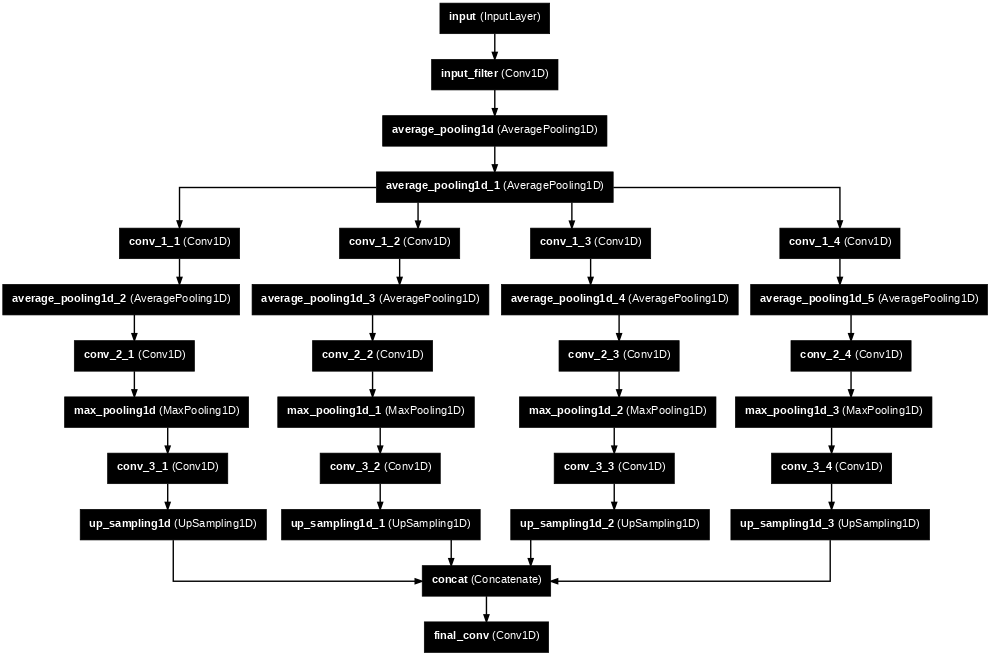

In [46]:
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model

# Plot the model graph and save to a temporary file
plot_model(
    loaded_model,
    to_file="simple_dtmf_classifier.png",
    show_shapes=False,
    show_layer_names=True,
    dpi=50,
)

# Display the plot inline
display(Image("simple_dtmf_classifier.png"))

In [47]:
def find_layer_by_name(model, layer_name):
    for layer in model.layers:
        if layer.name == layer_name:
            return layer
    return None

In [48]:
layer_names = [
    "conv_1_1",
    "conv_1_2",
    "conv_1_3",
    "conv_1_4",
    "conv_2_1",
    "conv_2_2",
    "conv_2_3",
    "conv_2_4",
    "input_filter",
]

amp_in_db = False

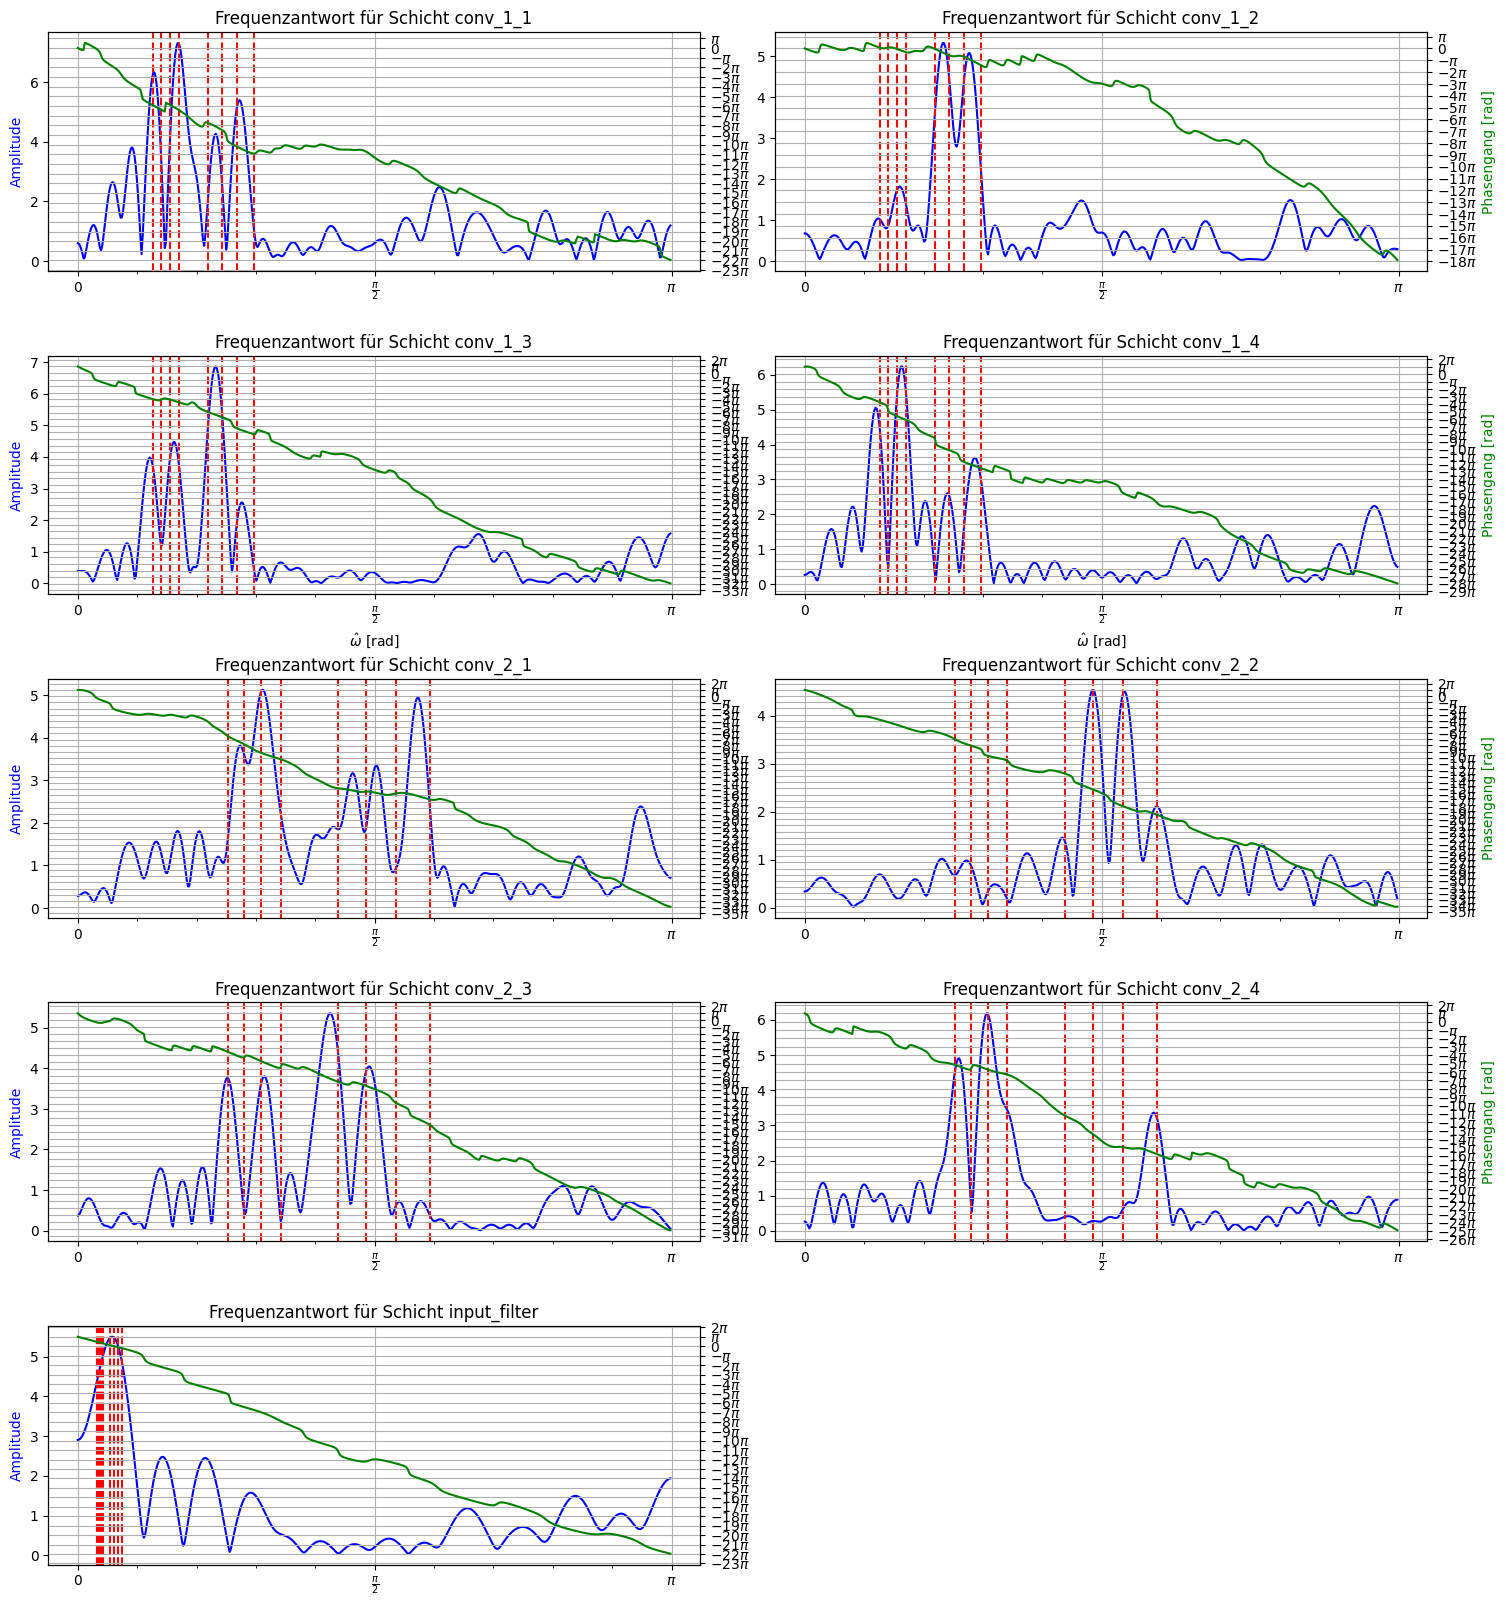

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from techdays25.plotting_utils import multiple_formatter

fig = plt.figure(figsize=(15, 16))

dil_rate = 1  # Is always 1 in this example...
debug = False

for idx, layer_name in enumerate(layer_names):
    layer = find_layer_by_name(loaded_model, layer_name=layer_name)

    # Print the name and weights of the n-th layer
    # print(f"Name der {n + 1}. Schicht (Index {n}): {layer_name}")
    # print(f"Gewichte der {n+1}. Schicht (Index {n}):\n", weights)

    weights = layer.get_weights()

    # The following is necessary, since we have several downsampling layers in the model
    # Note that this computation is specific to this particular model
    freq_multiplier = 1
    if "conv" in layer_name:
        freq_multiplier *= 2 ** (int(layer_name.split("_")[1]) + 1)

    frequencies = [
        freq_multiplier * 2.0 * np.pi * f / dtmf_gen.get_sample_rate()
        for f in dtmf_gen.FREQS
    ]

    if debug:
        print(
            f"Dimension des Layers: {layer.get_weights()[0].shape} (kernel_size x input_channels x  num_filters)"
        )  # (kernel_size, input_channels, num_filters)
        print("frequencies:", frequencies)
        print(f"Freq_multiplier for {layer_name}: {freq_multiplier}")
        print()

    b = weights[0][:, 0, 0]  # (kernel_size, channels, num_filters)
    w, h = signal.freqz(b[::-1])

    # Can be skipped in this example:
    if dil_rate > 1:
        m = b.shape
        out = np.zeros((dil_rate) * m[0], dtype=b.dtype)
        out[::dil_rate] = b
        b = out[: -dil_rate + 1]
        w, h = signal.freqz(b[::-1])

    ax1 = fig.add_subplot(521 + idx)

    # ax1.set_title("Dilation rate q=" + str(dil_rate))
    ax1.set_title(f"Frequenzantwort für Schicht {layer_name}")

    if amp_in_db:
        plt.plot(w, 20 * np.log10(abs(h)), "b")
    else:
        plt.plot(w, abs(h), "b")

    if idx % 2 == 0:
        plt.ylabel("Amplitude" + ("[dB]" if amp_in_db else ""), color="b")
    if idx // 2 == 1:
        plt.xlabel(r"$\hat\omega$ [rad]")  # Frequency [rad/sample]

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    # angles = angles % (2 * np.pi) - np.pi
    plt.plot(w, angles, "g")
    if idx % 2 == 1:
        plt.ylabel("Phasengang [rad]", color="g")
    plt.grid()
    # plt.axis('tight')

    ax1.xaxis.grid(True)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    ax2.yaxis.grid(True)
    ax2.yaxis.set_major_locator(plt.MultipleLocator(dil_rate * np.pi))
    # ax2.yaxis.set_minor_locator(plt.MultipleLocator(2*np.pi))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    # Plot vertical lines at specified frequencies
    if frequencies:
        for freq in frequencies:
            ax1.axvline(x=freq, color="r", linestyle="--")

plt.tight_layout(pad=0.5)
plt.show()

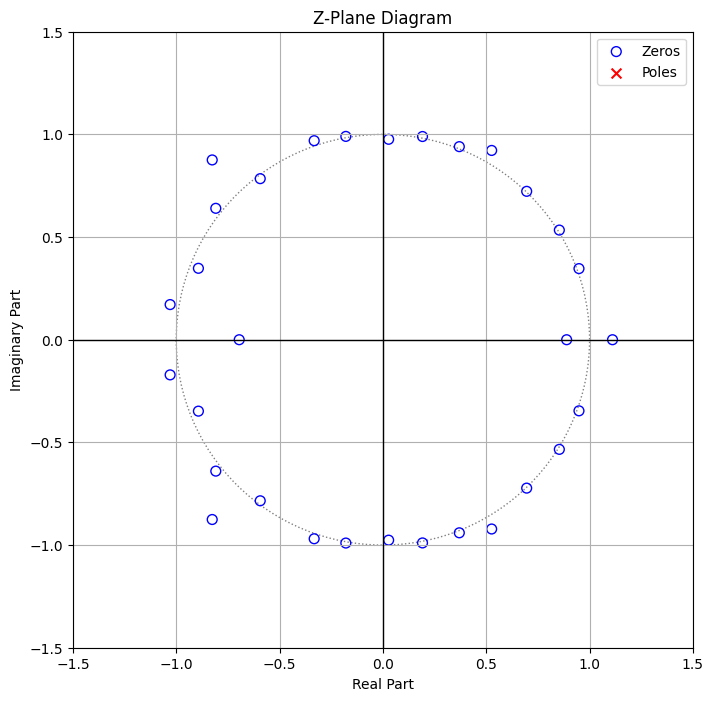

In [50]:
from techdays25.plotting_utils import zplane

# Plot the z-plane diagram for the FIR filter
zplane(b[::-1])

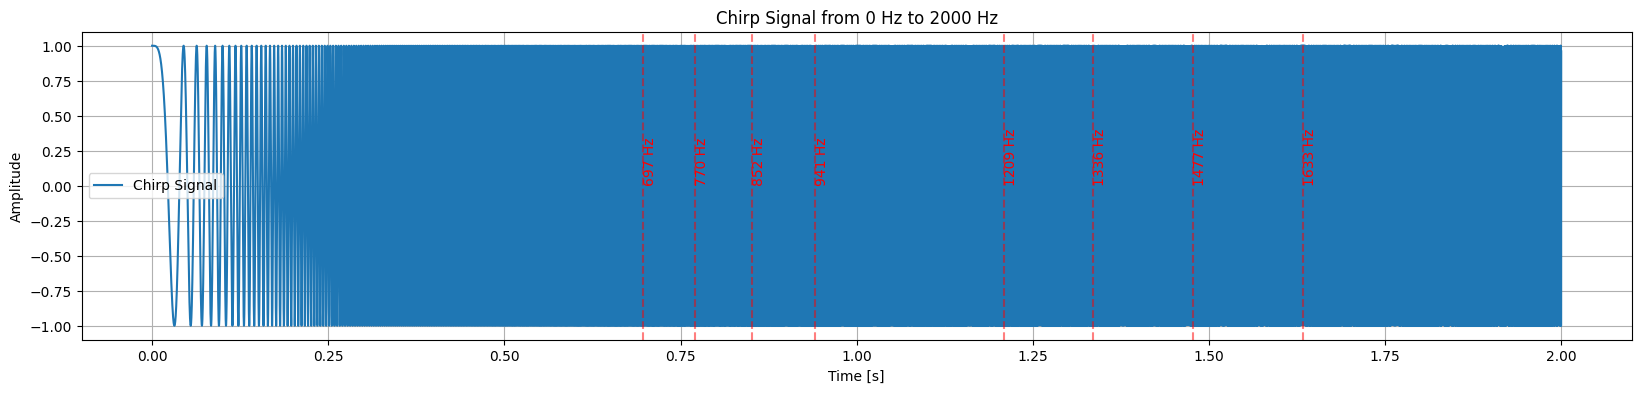

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp

# Define parameters
dur = 2.0  # Duration of the chirp signal in seconds
sample_rate = 44100  # Sampling rate in Hz
f1 = 0  # Start frequency of the chirp in Hz
f2 = 2000  # End frequency of the chirp in Hz

f_interest = [697, 770, 852, 941, 1209, 1336, 1477, 1633]

# Generate the time vector
tt = np.arange(0.0, dur, 1 / sample_rate)

# Generate the chirp signal
chirp_signal = chirp(tt, f0=f1, f1=f2, t1=dur, method="linear")

# Calculate the time points for the frequencies of interest
t_interest = [(f - f1) / (f2 - f1) * dur for f in f_interest]

# Plot the chirp signal
plt.figure(figsize=(20, 4))
plt.plot(tt, chirp_signal, label="Chirp Signal")

# Add markers for the frequencies of interest
for f, t in zip(f_interest, t_interest):
    plt.axvline(x=t, color="r", linestyle="--", alpha=0.5)
    plt.text(t, 0, f"{f} Hz", rotation=90, verticalalignment="bottom", color="r")

plt.title(f"Chirp Signal from {f1} Hz to {f2} Hz")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

In [52]:
result = recreated_intermediate_model.predict(chirp_signal.reshape(1, -1, 1))
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 88208, 4)

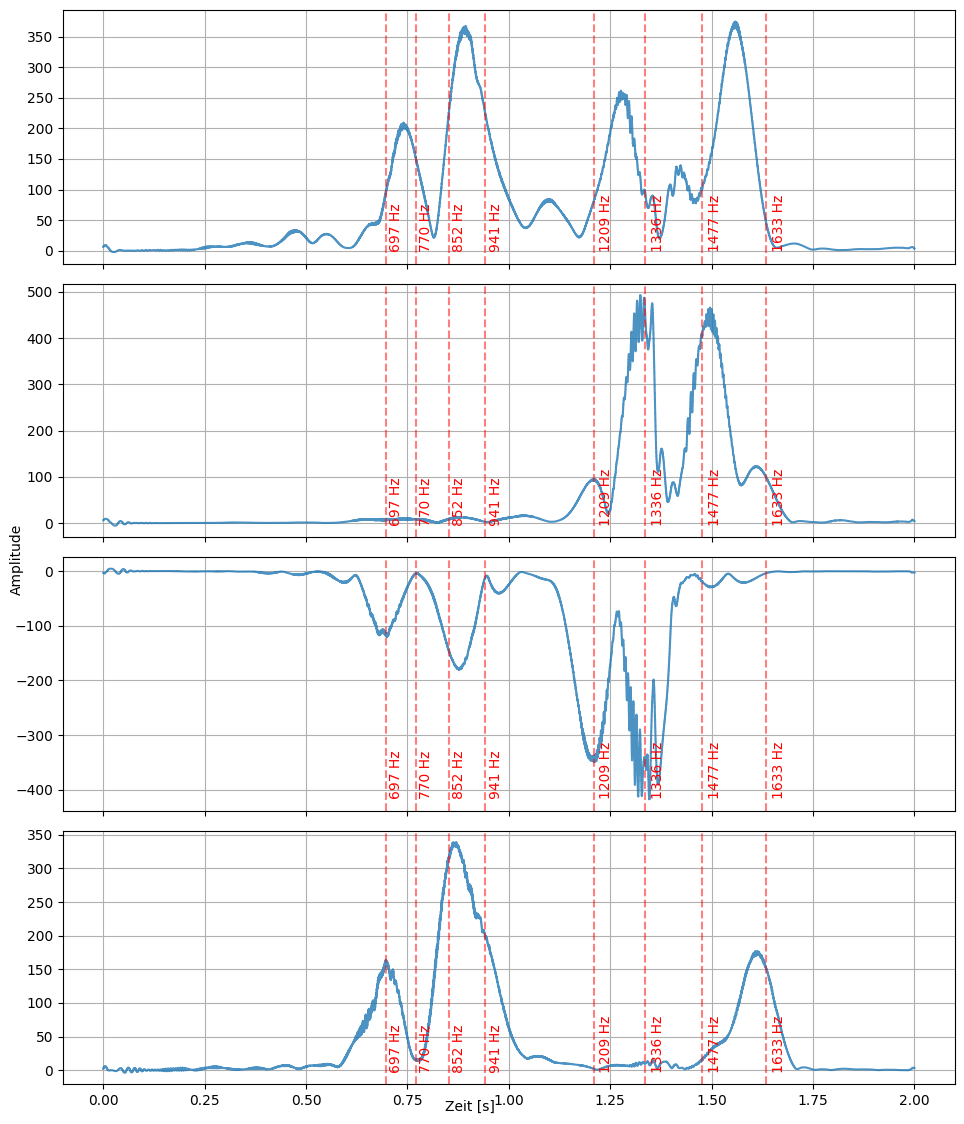

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example data (896x8)
# In practice, you would load your actual data here
data = result.squeeze()

# Create a figure with N subplots arranged vertically
fig, axes = plt.subplots(data.shape[-1], 1, figsize=(10, 12), sharex=True)

# Plot each time series in its respective subplot
for i in range(data.shape[-1]):
    ax_data = data[: len(tt), i]
    axes[i].plot(tt, ax_data, alpha=0.8)
    # axes[i].set_title(f'Time Series {i+1}')
    axes[i].grid(True)

    # Add markers for the frequencies of interest
    for f, t in zip(f_interest, t_interest):
        axes[i].axvline(x=t, color="r", linestyle="--", alpha=0.5)
        axes[i].text(
            t * 1.01,
            min(ax_data),
            f"{f} Hz",
            rotation=90,
            verticalalignment="bottom",
            color="r",
        )

# Set common labels
fig.text(0.5, 0.04, "Zeit [s]", ha="center")
fig.text(0.04, 0.5, "Amplitude", va="center", rotation="vertical")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

# Show the plot
plt.show()

## Trainingsprozess für das einfache obige Modell für die Analyse im Frequenzraum

In [ ]:
# from collections.abc import Callable
from pathlib import Path

import numpy as np
import tensorflow as tf
from scipy.io import wavfile
from tensorflow.keras import layers

In [ ]:
# This model can be used as a basis to analyze it in the frequency domain.
# It appears to show some interesting insights in the frequency domain.
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (
    None,
    1,
)  # Example: sequence length is variable, and there are 3 features per time step

# Input layer
inputs = Input(shape=input_shape, name="input")

# Learn a filter for the input:
conv_layer_input = Conv1D(
    filters=1,
    kernel_size=64,
    padding="same",
    activation="linear",
    name="input_filter",
    use_bias=False,
)(inputs)

# Do some downsampling first
avg_pooled = layers.AveragePooling1D(padding="same", pool_size=2)(conv_layer_input)
avg_pooled_1 = layers.AveragePooling1D(padding="same", pool_size=2)(avg_pooled)

# Define N different Conv1D layers
conv_layers = []
for i in range(10):
    conv_layer = Conv1D(
        filters=1,
        kernel_size=64,
        padding="same",
        activation="linear",
        name=f"conv_1_{i + 1}",
        use_bias=False,
    )(avg_pooled_1)

    max_pooled_layer = layers.AveragePooling1D(padding="same", pool_size=2)(conv_layer)
    conv_layer_1 = Conv1D(
        filters=1,
        kernel_size=64,
        padding="same",
        activation="linear",
        name=f"conv_2_{i + 1}",
        use_bias=False,
    )(max_pooled_layer)

    max_pooled_layer_2 = layers.MaxPooling1D(padding="same")(conv_layer_1)
    conv_layer_2 = Conv1D(
        filters=1,
        kernel_size=8,
        padding="same",
        activation="linear",
        name=f"conv_3_{i + 1}",
        use_bias=False,
    )(max_pooled_layer_2)

    upsamp_layer = layers.UpSampling1D(size=16)(conv_layer_2)

    conv_layers.append(upsamp_layer)

# Concatenate the outputs of the Conv1D layers
concatenated = Concatenate(name="concat")(conv_layers)

# Final 1x1 Conv1D layer with softmax activation
output = Conv1D(
    filters=dtmf_gen.get_num_keys() + 1,
    kernel_size=1,
    activation="softmax",
    name="final_conv",
    use_bias=False,
)(concatenated)

# Create the model
model = Model(inputs=inputs, outputs=output, name="MultiConv1DModel")

# Create an additional model to output the concatenated layer
intermediate_model = Model(
    inputs=inputs, outputs=concatenated, name="IntermediateModel"
)

# Print the model summary
model.summary()

In [ ]:
X_train, Y_train = dtmf_gen.generate_dataset(n_samples=1024, t_length=2**14)
X_val, Y_val = dtmf_gen.generate_dataset(n_samples=64, t_length=2**16)

print(X_train.shape, Y_train.shape, X_train.min(), X_train.max())
print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_val, Y_val))

In [ ]:
model.save("simple_dtmf_classifier.keras")

# Anhang 3: Experimente mit "Quantization Aware Training" in TensorFlow

In [ ]:
!pip install tensorflow-model-optimization

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras

In [ ]:
from techdays25.dtmf_generation import DtmfGenerator

dtmf_gen = DtmfGenerator(
    dur_key=(0.02, 0.1),
    dur_pause=(0.01, 0.05),
    noise_factor=(0.0, 60.0),
    noise_freq_range=(0.0, 20000.0),
)

In [ ]:
# Define the input shape
input_shape = (None, 1)
num_classes = dtmf_gen.get_num_keys() + 1

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Reshape((-1, input_shape[1], 1)),
    keras.layers.Conv2D(32, kernel_size=(32, 1), activation="relu", padding="same"),
    keras.layers.Conv2D(32, kernel_size=(32, 1), activation="relu", padding="same"),
    keras.layers.Conv2D(32, kernel_size=(32, 1), activation="relu", padding="same"),
    keras.layers.Conv2D(32, kernel_size=(32, 1), activation="relu", padding="same"),
    keras.layers.Conv2D(32, kernel_size=(32, 1), activation="relu", padding="same"),
    # Final layer
    keras.layers.Conv2D(
        num_classes, kernel_size=(1, 1), activation="softmax", padding="same"
    ),
    keras.layers.Reshape((-1, num_classes)),
])

model.summary()

In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  # multi-label

In [ ]:
X_train, Y_train = dtmf_gen.generate_dataset(n_samples=1024, t_length=2**14)
X_val, Y_val = dtmf_gen.generate_dataset(n_samples=64, t_length=2**16)


# X_train, Y_train = np.expand_dims(X_train, -1), np.expand_dims(Y_train, -2)
# X_val, Y_val = np.expand_dims(X_val, -1), np.expand_dims(Y_val, -2)

print(X_train.shape, Y_train.shape, X_train.min(), X_train.max())
print(X_val.shape, Y_val.shape, X_val.min(), X_val.max())

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

In [ ]:
model.save("pre_qat_dtmf_classifier.keras")

In [ ]:
import tensorflow_model_optimization as tfmot

# q_aware stands for for quantization aware.
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)  # throws error

# q_aware_model = tfmot.quantization.keras.quantize_annotate_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

q_aware_model.summary()

In [ ]:
q_aware_model.fit(
    X_train, Y_train, batch_size=64, epochs=2, validation_data=(X_val, Y_val)
)

In [ ]:
import onnx
import tensorflow as tf
import tf2onnx

which_model = "qat_dtmf_classifier"

my_model = q_aware_model if which_model == "qat_dtmf_classifier" else model


# This line sets the output names for the Keras model.
# It might throw an error, but the ONNX model should still be exported correctly.
my_model.output_names = ["output"]

# Define the input signature for the model.
# This specifies the shape and type of the input tensor.
# 'None' in the shape indicates a variable dimension, meaning the model can accept inputs of varying sizes.
input_signature = [tf.TensorSpec([None, None, 1], tf.float32, name="input")]

# Convert the Keras model to an ONNX model using the specified input signature and opset version.
# The opset version defines the set of operations available in the ONNX model.
onnx_model, _ = tf2onnx.convert.from_keras(my_model, input_signature, opset=18)

# Save the converted ONNX model to a file.
onnx.save(onnx_model, which_model + ".onnx")

# Anhang 4: ONNX INT8 Quantizatisierung vom DTMF-Klassifizierungsmodells

In [ ]:
from pathlib import Path
from typing import Any

import numpy as np
from onnxruntime.quantization import (
    CalibrationDataReader,
    QuantType,
    quantize_dynamic,
    quantize_static,
)
from onnxruntime.quantization.shape_inference import quant_pre_process

In [ ]:
onnx_model_path = Path("dtmf_classifier.onnx")
# First try static quantization and then switch to dynamic quantization
# and see how the results change
static_quantization = True  # toggles between static and dynamic quantization
onnx_model_path_int8 = onnx_model_path.stem + "_int8.onnx"

quant_pre_process(onnx_model_path, onnx_model_path_int8 + ".pre")


class CalibrationDataReaderImpl(CalibrationDataReader):
    """A class for constructing calibration data for the ONNX INT8 calibration."""

    def __init__(self) -> None:
        """Initialize the CalibrationDataReaderImpl.

        This class implements a calibration data reader for INT8 calibration.
        It generates synthetic data for calibration purposes.
        """
        self.counter: int = 0

    def get_next(self) -> dict[str, Any] | None:
        """Get the next batch of calibration data.

        This method generates synthetic data for calibration. It returns None after 16 batches.

        Returns:
            Optional[Dict[str, Any]]: A dictionary containing the input data for calibration,
            or None if there are no more batches.
        """
        if self.counter >= 16:
            return None
        self.counter += 1
        X = dtmf_gen.generate_dataset(
            n_samples=32, t_length=2**12, with_labels=None
        ).astype(np.float32)
        return {"input": X.astype(np.float32)}


# Prepare calibration data
calibration_data_reader = CalibrationDataReaderImpl()

if static_quantization:
    quantize_static(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        calibration_data_reader,
        # quant_format=QuantFormat.QOperator,
        per_channel=True,
        weight_type=QuantType.QInt8,
        extra_options={"CalibTensorRangeSymmetric": True},
    )
else:
    quantize_dynamic(
        onnx_model_path_int8 + ".pre",
        onnx_model_path_int8,
        weight_type=QuantType.QInt8,  # Quantize weights to int8
        per_channel=True,  # Enable per-channel quantization
        reduce_range=True,  # Reduce the quantization range
    )